In [104]:
import pandas as pd
import numpy as np
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('payments.csv', 'payments'),
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('order_items.csv', 'order_items')
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Thisisme_2010',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/user/OneDrive/Desktop/Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing payments.csv
NaN values before replacement:
order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64



KeyboardInterrupt: 

In [12]:
# importing the dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector 

# connecting the database
db = mysql.connector.connect( host = 'localhost',
                             username = 'root',
                             password = 'Thisisme_2010',
                             database = 'ecommerce')

# initialising a cursor that'll traverse the database
cur = db.cursor()

#### 1. List of all the unique cities where customers are located.

In [16]:
query = '''select distinct customer_city from customers'''

cur.execute(query)

data = cur.fetchall()
# this variable will store the output received from this particular query execution.
data

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

#### 2. Counting the number of orders made in 2017

In [19]:
query = '''select count(order_id) from orders where year(order_purchase_timestamp) = 2017'''

cur.execute(query)

data = cur.fetchall()

# data # this'll give a tuple
"The total number of orders made in 2017 are", data[0][0]

('The total number of orders made in 2017 are', 90202)

#### 3. Finding the total sales per category

In [26]:
query = '''select upper(products.product_category) Category, round(sum(payments.payment_value),2) Sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on order_items.order_id = payments.order_id
group by Category'''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Category', 'Sales'])
df

,Category,Sales
0,PERFUMERY,2026954.64
1,FURNITURE DECORATION,5720705.57
2,TELEPHONY,1947528.20
3,FASHION BAGS AND ACCESSORIES,872633.12
4,BED TABLE BATH,6850214.68
...,...,...
69,CDS MUSIC DVDS,4797.72
70,LA CUISINE,11654.12
71,FASHION CHILDREN'S CLOTHING,3142.68
72,PC GAMER,8697.72


> Since we used the sum function on the payment value, therefore it had to be grouped according to some condition. So groupby was used which distinguished the summation on the basis of category.

#### 4. Calculate the percentage of orders that were paid in installments.

In [35]:
query = '''select ((sum(case when payment_installments >=1 then 1 else 0 end))/count(*))*100 from payments'''

cur.execute(query)

data = cur.fetchall()

# data
# data[0][0]
float(data[0][0])

99.9981

#### 5. Counting the number of customers from each state


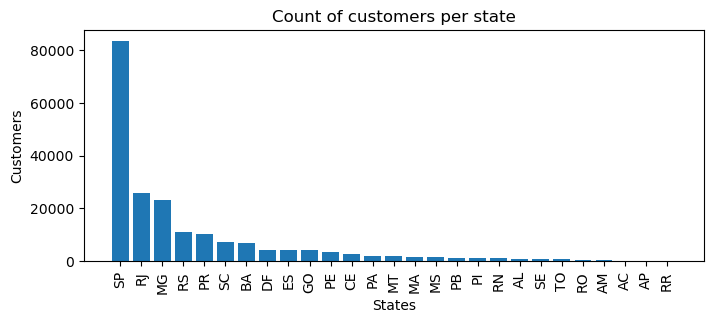

In [74]:
query = '''select customer_state, count(customer_id) from customers
group by customer_state'''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['States', 'Total Customers'])

# the values can also be sorted in the dataframe, which can also be viewed in the bar plot
df = df.sort_values(by = 'Total Customers', ascending= False)            # storing it back into the dataframe

# the size of plot can also be altered
plt.figure(figsize = (8,3))

plt.bar(df['States'], df['Total Customers'])
plt.xticks(rotation = 90)            # the x-labels were cluttered, therefore we rotated it to make it a bit clear to see
plt.xlabel("States")
plt.ylabel("Customers")
plt.title("Count of customers per state")
plt.show()

#### Calculate the number of orders per month in 2018

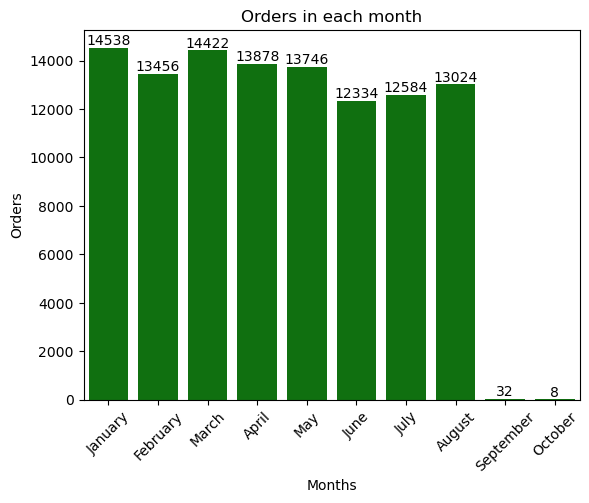

In [77]:
query = ''' select monthname(order_purchase_timestamp) Months, count(order_id) Orders
from orders where year(order_purchase_timestamp) = 2018 
group by months
'''
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns =['Months', 'Orders'])

# Now we want to plot this data, but the ordering function is not available in matplot, but seaborn.
o = ['January','February','March','April','May','June','July','August','September','October'] 

ax = sns.barplot(x = df['Months'], y = df['Orders'], data = df, order=o, color = "green")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Orders in each month")
plt.show()

#### 6. Find the average number of products per order, grouped by the customer city.

In [88]:
query = '''with count_per_order as(
select orders.order_id, orders.customer_id, count(order_items.order_id) as orderCount
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.orderCount),2) AvgOrders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
'''
# can add this : order by AvgOrders desc


cur.execute(query)

data=cur.fetchall()
df = pd.DataFrame(data, columns = ["City","Avg prod/ord"])
df.head(10)

# plt.bar(df['City'], df['Avg prod/ord'])
# plt.xticks(rotation = 90)            # the x-labels were cluttered, therefore we rotated it to make it a bit clear to see
# plt.xlabel("Cities")
# plt.ylabel("Average products per order")
# plt.show()

,City,Avg prod/ord
0,treze tilias,2.55
1,indaial,2.23
2,sao jose dos campos,2.28
3,sao paulo,2.31
4,porto alegre,2.35
5,santos,2.32
6,sao francisco do sul,2.47
7,sao vicente,2.18
8,joinville,2.21
9,sao vendelino,2.00


#### 8. Calculate the percentage of total revenue generated by each product category.

In [97]:
query = '''
select upper(products.product_category) Category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2)  PercentSales
from products join order_items
on products.product_id = order_items.product_id
join payments
on order_items.order_id = payments.order_id
group by Category order by PercentSales desc
'''

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Category','PercentSales'])

df

,Category,PercentSales
0,BED TABLE BATH,21.40
1,HEALTH BEAUTY,20.71
2,COMPUTER ACCESSORIES,19.81
3,FURNITURE DECORATION,17.87
4,WATCHES PRESENT,17.86
...,...,...
69,PC GAMER,0.03
70,HOUSE COMFORT 2,0.02
71,CDS MUSIC DVDS,0.01
72,FASHION CHILDREN'S CLOTHING,0.01


#### 9. Identifying the correlation between the product price and the number of times it has been purchased.

In [105]:
query = '''
select products.product_category,
count(products.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category
'''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Category', 'Number of purchase', 'Average Price'])

arr1 = df['Number of purchase']
arr2 = df['Average Price']

np.corrcoef([arr1, arr2])

array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

>  Conclusion: There no such positive or negative correlation. The number of times a product has been purchased isn't much associated to the change in price. 

#### 10. Calculate the total revenue generated by each seller, and rank them by revenue.


In [116]:
query = '''select order_items.seller_id, sum(payments.payment_value) Revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id
'''

cur.execute(query)

data = cur.fetchall()

data

[('1caf283236cd69af44cbc09a0a1e7d32', 3745.0800132751465),
 ('f8201cab383e484733266d1906e2fdfa', 2289.6599884033203),
 ('7c67e1448b00f6e969d365cea6b010ab', 1014333.8146042824),
 ('4869f7a5dfa277a7dca6462dcf3b52b2', 528332.2418775558),
 ('f8db351d8c4c4c22c6835c19a46f01b0', 153330.37999796867),
 ('1025f0e2d44d7041d6cf58b6550e0bfa', 616444.0796804428),
 ('2138ccb85b11a4ec1e37afbd1c8eda1f', 43698.59973907471),
 ('46dc3b2cc0980fb8ec44634e21d2718e', 297728.680141449),
 ('620c87c171fb2a6dd6e8bb4dec959fc6', 290535.8997352123),
 ('5ca5d579b5857ee8709479b1047cecc3', 727.7599945068359),
 ('1835b56ce799e6a4dc4eddc053f04066', 150511.46058273315),
 ('c003204e1ab016dfa150abc119207b24', 63323.01984024048),
 ('0432ead42b6c8a0bdf68154add917fdf', 20911.39991211891),
 ('5f67c6082caacb26e431a7b17940cece', 4124.099960327148),
 ('c3cfdc648177fdbbbb35635a37472c53', 117247.36017227173),
 ('9bade61a92bed55a25d2b67b9f4ed739', 575.3199996948242),
 ('f67efa3f0b6761102a7f8c6b7b571f5d', 12765.520004272461),
 ('7299e